https://gist.github.com/xiangze/7050d5746a6d953eb54e9c3e4007321f

In [2]:
import argparse
import logging
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.poutine as poutine
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal
from pyro.infer.abstract_infer import TracePredictive
from pyro.infer.mcmc import MCMC, NUTS

In [3]:
%matplotlib inline
plt.style.use('seaborn')
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [4]:
pyro.enable_validation(True)
DATA_URL = 'https://d2fefpcigoriu7.cloudfront.net/datasets/EfronMorrisBB.txt'
data = pd.read_csv(DATA_URL, '\t')
data.head()

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276


In [7]:
data.shape

(18, 10)

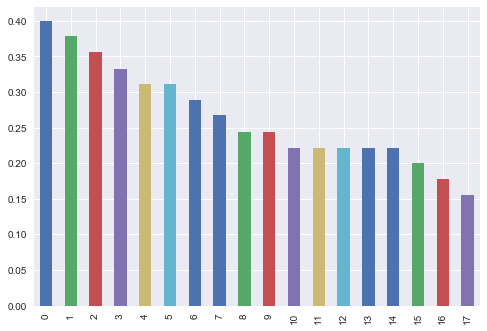

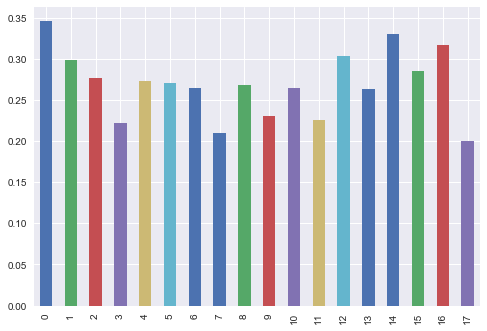

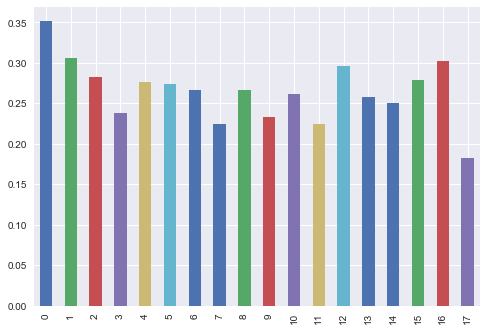

In [6]:
data['BattingAverage'].plot.bar()
plt.show()
data['RemainingAverage'].plot.bar()
plt.show()
data['SeasonAverage'].plot.bar()
plt.show()

In [8]:
def train_test_split(data):
    train_data = torch.tensor(data[['At-Bats', 'Hits']].values, dtype=torch.float)
    test_data = torch.tensor(data[['SeasonAt-Bats', 'SeasonHits']].values, dtype=torch.float)
    player_names = data['FirstName'] + ' ' + data['LastName']
    return train_data, test_data, player_names.values

In [9]:
train, _, player_names = train_test_split(data)
at_bats, hits = train[:, 0], train[:, 1]

In [10]:
data.columns

Index(['FirstName', 'LastName', 'At-Bats', 'Hits', 'BattingAverage',
       'RemainingAt-Bats', 'RemainingAverage', 'SeasonAt-Bats', 'SeasonHits',
       'SeasonAverage'],
      dtype='object')

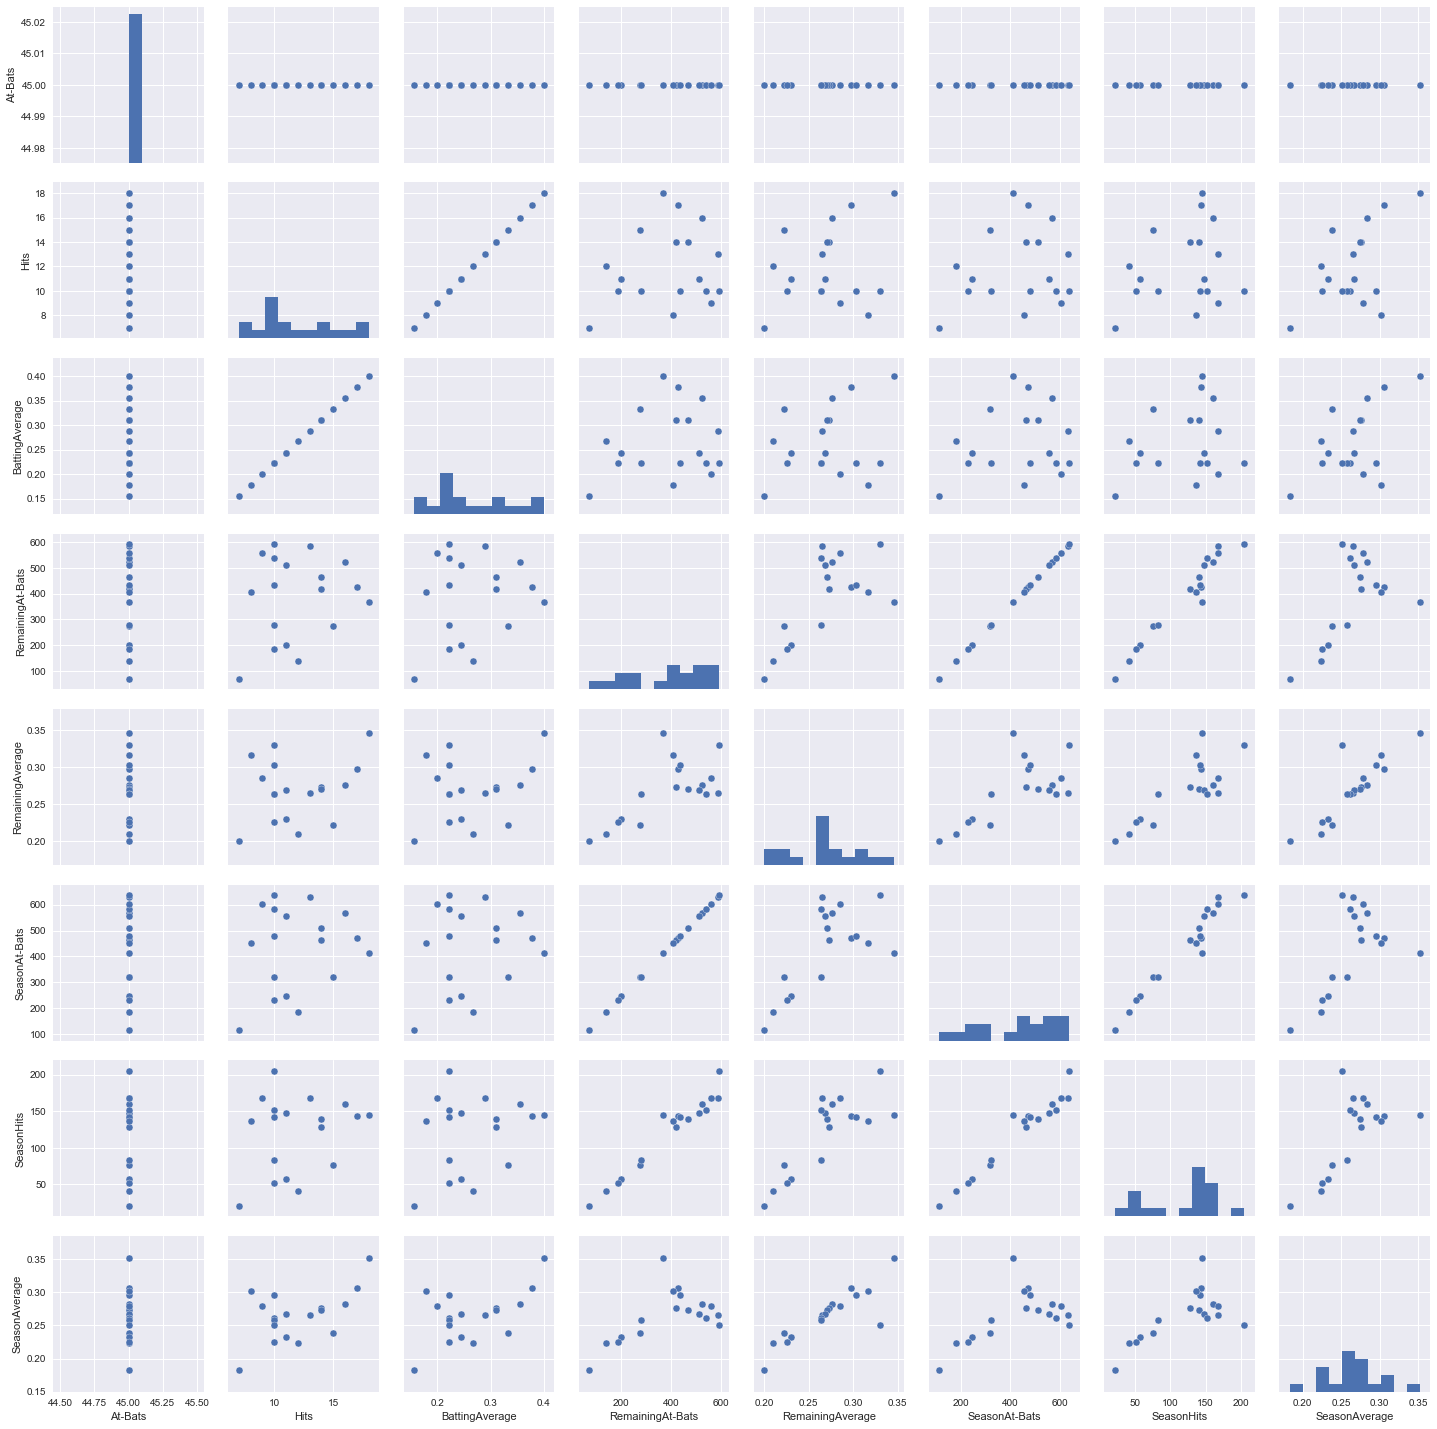

In [11]:
sns.pairplot(data[['At-Bats', 'Hits', 'BattingAverage', 
                   'RemainingAt-Bats', 'RemainingAverage',
                   'SeasonAt-Bats', 'SeasonHits', 'SeasonAverage']])

In [12]:
def fully_pooled(at_bats, hits):
    phi_prior = Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1))
    phi = pyro.sample('phi', phi_prior)
    return pyro.sample('obs', Binomial(at_bats, phi), obs=hits)

In [13]:
def not_pooled(at_bats, hits):
    num_players = at_bats.shape[0]
    with pyro.plate('num_players', num_players):
        phi_prior = Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1))
        phi = pyro.sample('phi', phi_prior)
        return pyro.sample('obs', Binomial(at_bats, phi), obs=hits)

In [14]:
def partially_pooled(at_bats, hits):
    num_players = at_bats.shape[0]
    m = pyro.sample('m', Uniform(at_bats.new_tensor(0), at_bats.new_tensor(1)))
    kappa = pyro.sample('kappa',
                        Pareto(at_bats.new_tensor(1), at_bats.new_tensor(1.5)))
    with pyro.plate('num_players', num_players):
        phi_prior = Beta(m*kappa, (1-m)*kappa)
        phi = pyro.sample('phi', phi_prior)
        return pyro.sample('obs', Binomial(at_bats, phi), obs=hits)

In [15]:
def partially_pooled_with_logit(at_bats, hits):
    num_players = at_bats.shape[0]
    loc = pyro.sample('loc', Normal(at_bats.new_tensor(-1), at_bats.new_tensor(1)))
    scale = pyro.sample('scale', HalfCauchy(scale=at_bats.new_tensor(1)))
    with pyro.plate('num_players', num_players):
        alpha = pyro.sample('alpha', Normal(loc, scale))
        return pyro.sample('obs', Binomial(at_bats, logits=alpha), obs=hits)

In [25]:
def get_site_stats(array, player_names):
    if len(array.shape) == 1:
        df = pd.DataFrame(array).transpose()
    else:
        df = pd.DataFrame(array, columns=player_names).transpose()
    return df.apply(pd.Series.describe, axis=1)[['mean', 'std', '25%', '50%', '75%']]


def summary(trace_posterior, sites, player_names, transforms={}, diagnostics=True):
    marginal = trace_posterior.marginal(sites)
    site_stats = {}
    for site_name in sites:
        marginal_site = marginal.support(flatten=True)[site_name]
        if site_name in transforms:
            marginal_site = transforms[site_name](marginal_site)
        
        site_stats[site_name] = get_site_stats(marginal_site.numpy(), player_names)
        if diagnostics and trace_posterior.num_chains > 1:
            diag = marginal.diagnostics()[site_name]
            site_stats[site_name] = site_stats[site_name].assign(
                n_eff=diag['n_eff'].numpy(), r_hat=diag['r_hat'].numpy())
    return site_stats

In [17]:
def sample_posterior_predictive(posterior_predictive, data):
    train, test, player_names = train_test_split(data)
    at_bats = train[:, 0]
    at_bats_season = test[:, 0]
    logging.Formatter('%(message)s')
    logging.info('\nPosterior Predictive:')
    logging.info('Hit Rate - Initial 45 At Bats')
    logging.info('--------------------------')
    train_predict = posterior_predictive.run(at_bats, None)
    train_summary = summary(train_predict, sites=['obs'],
                            player_names=player_names, diagnostics=False)['obs']
    train_summary = train_summary.assign(ActualHits=data[['Hits']].values)
    logging.info(train_summary)
    logging.info('\nHit Rate - Season Predictions')
    logging.info('--------------------------')
    test_predict = posterior_predictive.run(at_bats_season, None)
    test_summary = summary(test_predict, sites=['obs'],
                           player_names=player_names, diagnostics=False)['obs']
    test_summary = test_summary.assign(ActualHits=data[['SeasonHits']].values)
    logging.info(test_summary)
    

def evaluate_log_predictive_density(posterior_predictive, data):
    _, test, player_names = train_test_split(data)
    at_bats_season, hits_season = test[:, 0], test[:, 1]
    test_eval = posterior_predictive.run(at_bats_season, hits_season)
    trace_log_pdf = []
    for tr in test_eval.exec_traces:
        trace_log_pdf.append(tr.log_prob_sum())
    posterior_pred_density = logsumexp(torch.stack(trace_log_pdf), dim=-1) - \
        math.log(len(trace_log_pdf))
    logging.info('\nLog posterior predictive density')
    logging.info('--------------------------')
    logging.info('{:.4f}\n'.format(posterior_pred_density))

In [18]:
num_samples = 200
num_chains = 3
warmup_steps = 100

num_predictive_samples = num_samples * num_chains

In [19]:
rng_seed = 52
pyro.set_rng_seed(rng_seed)

In [21]:
nuts_kernel = NUTS(fully_pooled)
posterior_fully_pooled = MCMC(nuts_kernel,
                              num_samples=num_samples,
                              warmup_steps=warmup_steps,
                              num_chains=num_chains).run(at_bats, hits)
logging.info('\nModel: Fully Pooled')
logging.info('========================')
logging.info('\nphi:')
logging.info(summary(posterior_fully_pooled,
                     sites=['phi'],
                     player_names=player_names)['phi'])
posterior_predictive = TracePredictive(fully_pooled,
                                       posterior_fully_pooled,
                                       num_samples=num_predictive_samples)
sample_posterior_predictive(posterior_predictive, data)
evaluate_log_predictive_density(posterior_predictive, data)

HBox(children=(IntProgress(value=0, description='Warmup [1]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [2]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [3]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))


Model: Fully Pooled

phi:
       mean       std       25%       50%       75%       n_eff     r_hat
0  0.267115  0.015634  0.254908  0.267284  0.278384  282.003448  1.012708

Posterior Predictive:
Hit Rate - Initial 45 At Bats
--------------------------
                  mean  std   25%   50%   75%  ActualHits
Roberto Clemente  18.0  0.0  18.0  18.0  18.0          18
Frank Robinson    17.0  0.0  17.0  17.0  17.0          17
Frank Howard      16.0  0.0  16.0  16.0  16.0          16
Jay Johnstone     15.0  0.0  15.0  15.0  15.0          15
Ken Berry         14.0  0.0  14.0  14.0  14.0          14
Jim Spencer       14.0  0.0  14.0  14.0  14.0          14
Don Kessinger     13.0  0.0  13.0  13.0  13.0          13
Luis Alvarado     12.0  0.0  12.0  12.0  12.0          12
Ron Santo         11.0  0.0  11.0  11.0  11.0          11
Ron Swaboda       11.0  0.0  11.0  11.0  11.0          11
Rico Petrocelli   10.0  0.0  10.0  10.0  10.0          10
Ellie Rodriguez   10.0  0.0  10.0  10.0  10.0    

In [22]:
nuts_kernel = NUTS(not_pooled)
posterior_not_pooled = MCMC(nuts_kernel,
                            num_samples=num_samples,
                            warmup_steps=warmup_steps,
                            num_chains=num_chains).run(at_bats, hits)
logging.info('\nModel: Not Pooled')
logging.info('========================')
logging.info('\nphi:')
logging.info(summary(posterior_not_pooled,
                     sites=['phi'],
                     player_names=player_names)['phi'])
posterior_predictive = TracePredictive(not_pooled,
                                       posterior_not_pooled,
                                       num_samples=num_predictive_samples)
sample_posterior_predictive(posterior_predictive, data)
evaluate_log_predictive_density(posterior_predictive, data)

HBox(children=(IntProgress(value=0, description='Warmup [1]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [2]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [3]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))


Model: Not Pooled

phi:
                      mean       std       25%       50%       75%  \
Roberto Clemente  0.399943  0.075035  0.346843  0.396658  0.452164   
Frank Robinson    0.380921  0.070193  0.334455  0.375778  0.428543   
Frank Howard      0.362561  0.071634  0.312462  0.358348  0.413378   
Jay Johnstone     0.336355  0.071878  0.289077  0.329880  0.382827   
Ken Berry         0.314747  0.065654  0.270413  0.310458  0.356329   
Jim Spencer       0.315158  0.062964  0.268278  0.311988  0.358840   
Don Kessinger     0.301659  0.068475  0.252892  0.298465  0.349038   
Luis Alvarado     0.283721  0.062200  0.239647  0.282782  0.324852   
Ron Santo         0.258056  0.059806  0.215130  0.255764  0.297286   
Ron Swaboda       0.256684  0.067631  0.208116  0.255430  0.299480   
Rico Petrocelli   0.229894  0.059704  0.186203  0.224607  0.270622   
Ellie Rodriguez   0.236017  0.057246  0.191330  0.234975  0.274804   
George Scott      0.234043  0.059666  0.190660  0.231042  0.27455

In [23]:
nuts_kernel = NUTS(partially_pooled)
posterior_partially_pooled = MCMC(nuts_kernel,
                                  num_samples=num_samples,
                                  warmup_steps=warmup_steps,
                                  num_chains=num_chains).run(at_bats, hits)
logging.info('\nModel: Partially Pooled')
logging.info('========================')
logging.info('\nphi:')
logging.info(summary(posterior_partially_pooled,
                     sites=['phi'],
                     player_names=player_names)['phi'])
posterior_predictive = TracePredictive(partially_pooled,
                                       posterior_partially_pooled,
                                       num_samples=num_predictive_samples)
sample_posterior_predictive(posterior_predictive, data)
evaluate_log_predictive_density(posterior_predictive, data)

HBox(children=(IntProgress(value=0, description='Warmup [1]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [2]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [3]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))


Model: Partially Pooled

phi:
                      mean       std       25%       50%       75%  \
Roberto Clemente  0.330732  0.056697  0.287433  0.329061  0.367337   
Frank Robinson    0.318623  0.053476  0.281985  0.313461  0.349818   
Frank Howard      0.312894  0.053505  0.274333  0.307558  0.347047   
Jay Johnstone     0.295636  0.050027  0.261132  0.291267  0.324851   
Ken Berry         0.288313  0.046968  0.256531  0.284000  0.318049   
Jim Spencer       0.287504  0.045141  0.256558  0.284777  0.318844   
Don Kessinger     0.278573  0.048426  0.246480  0.277425  0.309384   
Luis Alvarado     0.266445  0.045962  0.236697  0.264992  0.295940   
Ron Santo         0.259523  0.047678  0.228490  0.259872  0.289555   
Ron Swaboda       0.259049  0.046129  0.228279  0.256043  0.290896   
Rico Petrocelli   0.246646  0.045131  0.216728  0.246783  0.272855   
Ellie Rodriguez   0.244179  0.048296  0.213908  0.244600  0.277833   
George Scott      0.249798  0.044556  0.220636  0.249137  0

In [26]:
nuts_kernel = NUTS(partially_pooled_with_logit)
posterior_partially_pooled_with_logit = MCMC(nuts_kernel,
                                             num_samples=num_samples,
                                             warmup_steps=warmup_steps,
                                             num_chains=num_chains).run(at_bats, hits)
logging.info('\nModel: Partially Pooled with Logit')
logging.info('========================')
logging.info('\nSigmoid (alpha):')
logging.info(summary(posterior_partially_pooled_with_logit,
                     sites=['alpha'],
                     player_names=player_names,
                     transforms={'alpha': lambda x: 1. / (1 + (-x).exp())})['alpha'])
posterior_predictive = TracePredictive(partially_pooled_with_logit,
                                       posterior_partially_pooled_with_logit,
                                       num_samples=num_predictive_samples)
sample_posterior_predictive(posterior_predictive, data)
evaluate_log_predictive_density(posterior_predictive, data)

HBox(children=(IntProgress(value=0, description='Warmup [1]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [2]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Warmup [3]', max=300, style=ProgressStyle(description_width='initial')), HTML(value='')))


Model: Partially Pooled with Logit

Sigmoid (alpha):
                      mean       std       25%       50%       75%  \
Roberto Clemente  0.296156  0.040719  0.266291  0.290531  0.320242   
Frank Robinson    0.290568  0.039773  0.264530  0.284151  0.312349   
Frank Howard      0.287571  0.039618  0.261698  0.280873  0.308512   
Jay Johnstone     0.281311  0.036731  0.254630  0.278680  0.301954   
Ken Berry         0.275172  0.034034  0.251361  0.273174  0.296399   
Jim Spencer       0.275183  0.038243  0.248527  0.271953  0.294773   
Don Kessinger     0.269896  0.034686  0.246947  0.265581  0.290342   
Luis Alvarado     0.265240  0.035537  0.244533  0.264933  0.287217   
Ron Santo         0.259697  0.034639  0.239275  0.262939  0.279452   
Ron Swaboda       0.260685  0.035905  0.235296  0.259989  0.281871   
Rico Petrocelli   0.253204  0.034641  0.232819  0.255023  0.273528   
Ellie Rodriguez   0.254260  0.031659  0.235744  0.254733  0.273609   
George Scott      0.253762  0.032302